In [51]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from datetime import datetime
from string import punctuation,digits
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
# read train data
df = pd.read_csv("/content/drive/MyDrive/datasets/case study1: aspect based sentiment analysis/01.data/final_tr_v2.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
print(df.shape)

(1303, 2)


In [53]:
df.head(2)

,sentence,target
0,Royal Mail chairman Donald Brydon set to step ...,Appointment
1,Slump in Weir leads FTSE down from record high,Volatility


# 01. Cleaning the dataset

In [54]:
def remove_punctuation(s):
    list_punctuation = list(punctuation)
    for i in list_punctuation:
        s = s.replace(i,' ')
    return s

def clean_sentence(sentence):
    sentence = sentence.lower()
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    sentence = sentence.replace("'s",'')
    sentence = sentence.replace("-",' ')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    tokens = [remove_punctuation(w) for w in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    remove_digits = str.maketrans('', '', digits)
    tokens = [w.translate(remove_digits) for w in tokens]
    tokens = [w.strip() for w in tokens]
    tokens = [w for w in tokens if w!=""]
    tokens = ' '.join(tokens)
    return tokens

In [55]:
df["cleaned_sentence"] = [clean_sentence(x) for x in df.sentence]
df.drop(["sentence"], axis=1, inplace=True)
df.head(2)

,target,cleaned_sentence
0,Appointment,royal mail chairman donald brydon set step
1,Volatility,slump weir leads ftse record high


# 2. Creating 2 datasets one for binary classification and other for multiclass classification.

- Binary classification - for the largest target value (Price Action) vs others
- Multiclass classification - for others

In [56]:
# binary dataset
df_binary = df.copy(deep=True)
df_binary["target_binary"] = [1 if x == "Price Action" else 0 for x in df_binary.target]
df_binary.drop(["target"], axis=1, inplace=True)
df_binary.head(2)

,cleaned_sentence,target_binary
0,royal mail chairman donald brydon set step,0
1,slump weir leads ftse record high,0


In [57]:
# multiclass dataset
df_multi = df[df.target != "Price Action"]
df_multi.head(2)

,target,cleaned_sentence
0,Appointment,royal mail chairman donald brydon set step
1,Volatility,slump weir leads ftse record high


# 3. Binary classification modelling

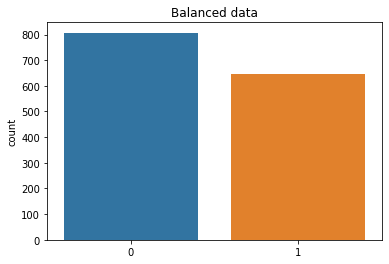

In [ ]:
# oversampling
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy=0.8)

# fit and apply the transform
X, y = oversample.fit_resample(df_binary.drop(["target_binary"], 1), df_binary.drop(["cleaned_sentence"], 1))

# plotting to check the difference
sns.countplot(y)
plt.title("Balanced data")
plt.show()

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(X_train.shape, X_test.shape)

(1161, 1) (291, 1)


## 3.1 tf-idf and sentiments featurization

In [ ]:
# embedding text using tf-idf
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer_tf = TfidfVectorizer()
vectorizer_tf.fit(X_train.reshape(1,-1)[0]) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_tf.transform(X_train.reshape(1,-1)[0])
X_test_essay_tfidf = vectorizer_tf.transform(X_test.reshape(1,-1)[0])

tfidf_essay = vectorizer_tf.get_feature_names() # for finding important features

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

(1161, 1) (1161,)
(291, 1) (291,)
After vectorizations
(1161, 3156) (1161,)
(291, 3156) (291,)


In [ ]:
# using sentiment analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

sid = SentimentIntensityAnalyzer()

X_train_cleaned_sentence_sentiment = list()
for i in range(len(X_train.reshape(1,-1)[0])):
    ss = sid.polarity_scores(X_train.reshape(1,-1)[0][i])
    X_train_cleaned_sentence_sentiment.append(list(ss.values()))

X_test_cleaned_sentence_sentiment = list()
for i in range(len(X_test.reshape(1,-1)[0])):
    ss = sid.polarity_scores(X_test.reshape(1,-1)[0][i])
    X_test_cleaned_sentence_sentiment.append(list(ss.values()))

X_train_cleaned_sentence_sentiment = np.array(X_train_cleaned_sentence_sentiment)
X_test_cleaned_sentence_sentiment = np.array(X_test_cleaned_sentence_sentiment)

print("After Sentiment scores")
print(X_train_cleaned_sentence_sentiment.shape, y_train.shape)
print(X_test_cleaned_sentence_sentiment.shape, y_test.shape)
print("="*100)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
(1161, 1) (1161,)
(291, 1) (291,)
After Sentiment scores
(1161, 4) (1161,)
(291, 4) (291,)


In [ ]:
# set 1 - feature set
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf, X_train_cleaned_sentence_sentiment)).tocsr()
X_te = hstack((X_test_essay_tfidf, X_test_cleaned_sentence_sentiment)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(1161, 3160) (1161,)
(291, 3160) (291,)


## 3.2 XG boost on tfidf + sentiments

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# hyperparameters
params = {
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
}

In [ ]:
import xgboost as XGB
xgb_model = XGB.XGBClassifier()
clf = RandomizedSearchCV(xgb_model, params, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=10)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.6s finished


In [ ]:
print("Best hyperparameters: {}".format(clf.best_params_))

Best hyperparameters: {'max_depth': 5, 'n_estimators': 148}


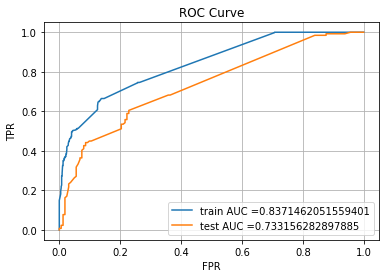

Text(0.5, 1.0, 'Confusion Matrix')

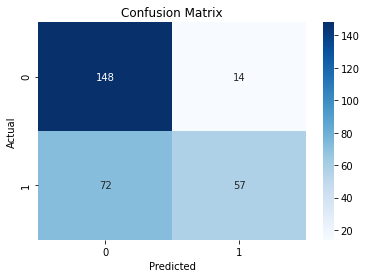

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

# we will use the above parameters and add regularization to avoid overfitting
mnb = clf.best_estimator_
mnb.fit(X_tr, y_train, early_stopping_rounds=5, eval_set=[(X_te, y_test)], verbose=False)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = mnb.predict_proba(X_tr) 
y_test_pred = mnb.predict_proba(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred[:, 1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:, 1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   
cm = confusion_matrix(y_test, mnb.predict(X_te))
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

## 3.3 Universal sentence encoder featurization

In [ ]:
# encoding using Universal sentence encoder
# using universal sentence encoder for text embedding
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
embeddings_train = embed(X_train.reshape(1,-1)[0])
embeddings_test = embed(X_test.reshape(1,-1)[0])
embeddings_train.shape, embeddings_test.shape

(TensorShape([1161, 512]), TensorShape([291, 512]))

## 3.4 XG boost on USE

In [ ]:
# hyperparameters
params = {
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
}

xgb_model = XGB.XGBClassifier()
clf = RandomizedSearchCV(xgb_model, params, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=10)
clf.fit(np.array(embeddings_train), y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
print("Best hyperparameters: {}".format(clf.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.7min finished


Best hyperparameters: {'max_depth': 4, 'n_estimators': 149}


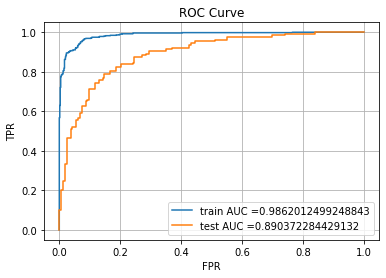

Text(0.5, 1.0, 'Confusion Matrix')

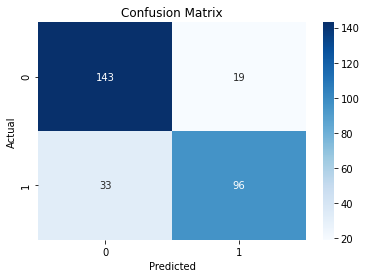

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
embeddings_train = np.array(embeddings_train)
embeddings_test = np.array(embeddings_test)

# we will use the above parameters and add regularization to avoid overfitting
mnb = clf.best_estimator_
mnb.fit(embeddings_train, y_train, early_stopping_rounds=5, eval_set=[(embeddings_test, y_test)], verbose=False)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = mnb.predict_proba(embeddings_train) 
y_test_pred = mnb.predict_proba(embeddings_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred[:, 1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:, 1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   
cm = confusion_matrix(y_test, mnb.predict(embeddings_test))
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

## 3.5 KNN on USE

In [ ]:
# KNN
# hyperparameters
from sklearn.neighbors import KNeighborsClassifier
params = {
    "n_neighbors": randint(3, 50) # default 5
}

knn = KNeighborsClassifier()
clf = RandomizedSearchCV(knn, params, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=10)
clf.fit(np.array(embeddings_train), y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
print("Best hyperparameters: {}".format(clf.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.3s


Best hyperparameters: {'n_neighbors': 18}


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.3s finished


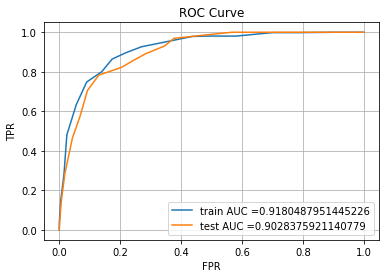

Text(0.5, 1.0, 'Confusion Matrix')

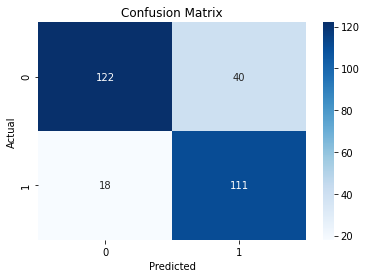

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
embeddings_train = np.array(embeddings_train)
embeddings_test = np.array(embeddings_test)

# we will use the above parameters and add regularization to avoid overfitting
mnb = clf.best_estimator_
mnb.fit(embeddings_train, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = mnb.predict_proba(embeddings_train) 
y_test_pred = mnb.predict_proba(embeddings_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred[:, 1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:, 1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   
cm = confusion_matrix(y_test, mnb.predict(embeddings_test))
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

## Observationn - KNN + universal sentence encoder embeddings seems to be the best model to work for this binary classification problem and since the number of points are not much we can use this in production no problem

# 4. Multiclass classification problem

In [58]:
df_multi.head()

,target,cleaned_sentence
0,Appointment,royal mail chairman donald brydon set step
1,Volatility,slump weir leads ftse record high
2,Regulatory,astrazeneca wins fda approval key new lung can...
3,Strategy,update lloyds cut jobs part year restructuring...
4,Strategy,standard chartered shifts emerging markets str...


In [59]:
# oversample anything less than 10
li_under25 = list(df_multi.target.value_counts()[df_multi.target.value_counts() < 10].index)
index_under25 = df_multi[df_multi.target.isin(li_under25)].index
df_under25 = df_multi[df_multi.target.isin(li_under25)]
df_under25.shape
df_multi.drop(index_under25, axis=0, inplace=True)

In [60]:
# oversampling points below 25 rows 
from imblearn.over_sampling import RandomOverSampler
X_resampled, y_resampled = RandomOverSampler().fit_resample(df_under25.cleaned_sentence.values.reshape(-1,1), df_under25.target)
print(X_resampled.shape, y_resampled.shape)
# creating a dataframe
df_resampled = pd.DataFrame({"target":y_resampled, "cleaned_sentence":X_resampled.reshape(1,-1)[0]})
df_resampled.shape

(63, 1) (63,)


(63, 2)

In [61]:
# appending the 2 dataframes
df_multi = pd.concat([df_multi, df_resampled], axis=0, ignore_index=True)
df_multi.shape

(834, 2)

In [62]:
# USE embeddings
embeddings_data_use = embed(df_multi.cleaned_sentence)
embeddings_data_use = np.array(embeddings_data_use)

In [63]:
# encoding labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_y = le.fit_transform(df_multi.target)

In [64]:
# train, test, CV splt
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(embeddings_data_use, data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [65]:
print(np.unique(y_train), len(np.unique(y_train)))
print(np.unique(y_cv), len(np.unique(y_cv)))
print(np.unique(y_test), len(np.unique(y_test)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] 26
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] 26
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] 26


In [66]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 533
Number of data points in test data: 167
Number of data points in cross validation data: 134


In [71]:
# custom function 
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(20,10))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(20,10))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(20,10))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

## 4.1 KNN for multiclass using Universal sentence encoder embeddings

log_loss for k =  1 is 2.1246907534414743
log_loss for k =  3 is 1.9559758819965645
log_loss for k =  5 is 1.9211704933153768
log_loss for k =  7 is 1.871092299144852
log_loss for k =  9 is 1.841541964647245
log_loss for k =  11 is 1.8107878250893723
log_loss for k =  13 is 1.8053876210754087
log_loss for k =  15 is 1.7986399961332027
log_loss for k =  17 is 1.7939619996619205
log_loss for k =  19 is 1.78983630394759
log_loss for k =  21 is 1.7966945736504976


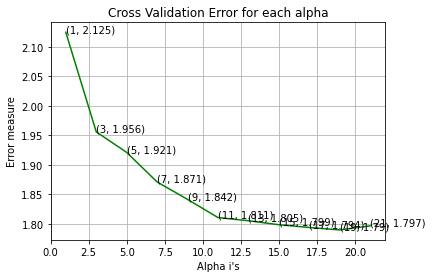

For values of best alpha =  19 The train log loss is: 1.6296428743090579
For values of best alpha =  19 The cross validation log loss is: 1.78983630394759
For values of best alpha =  19 The test log loss is: 1.735712535806895
Number of misclassified points  43.11377245508982
-------------------------------------------------- Confusion matrix --------------------------------------------------


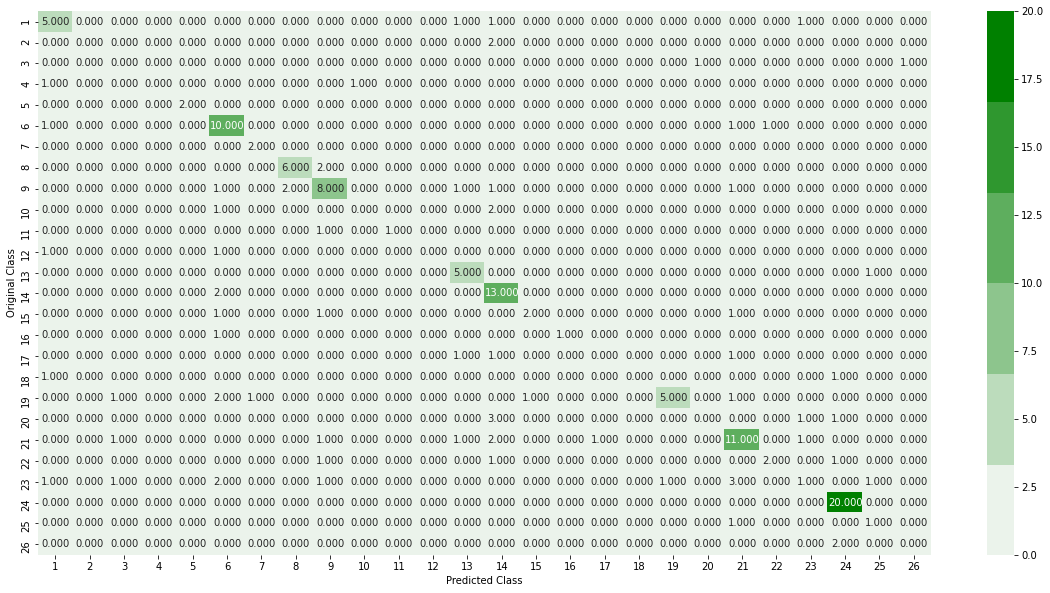

-------------------------------------------------- Precision matrix --------------------------------------------------


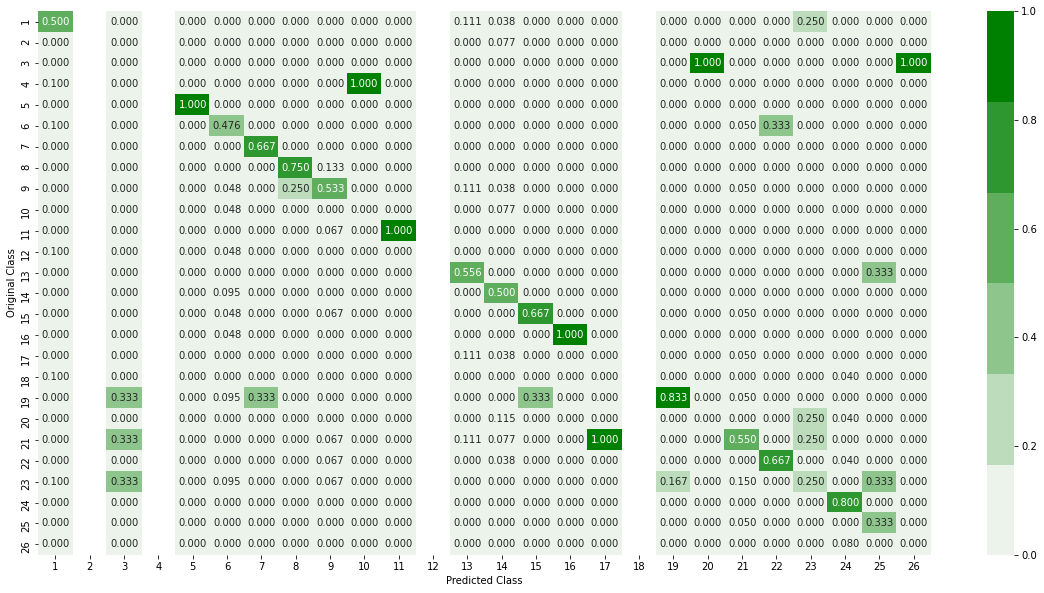

Sum of columns in precision matrix [ 1. nan  1. nan  1.  1.  1.  1.  1.  1.  1. nan  1.  1.  1.  1.  1. nan
  1.  1.  1.  1.  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


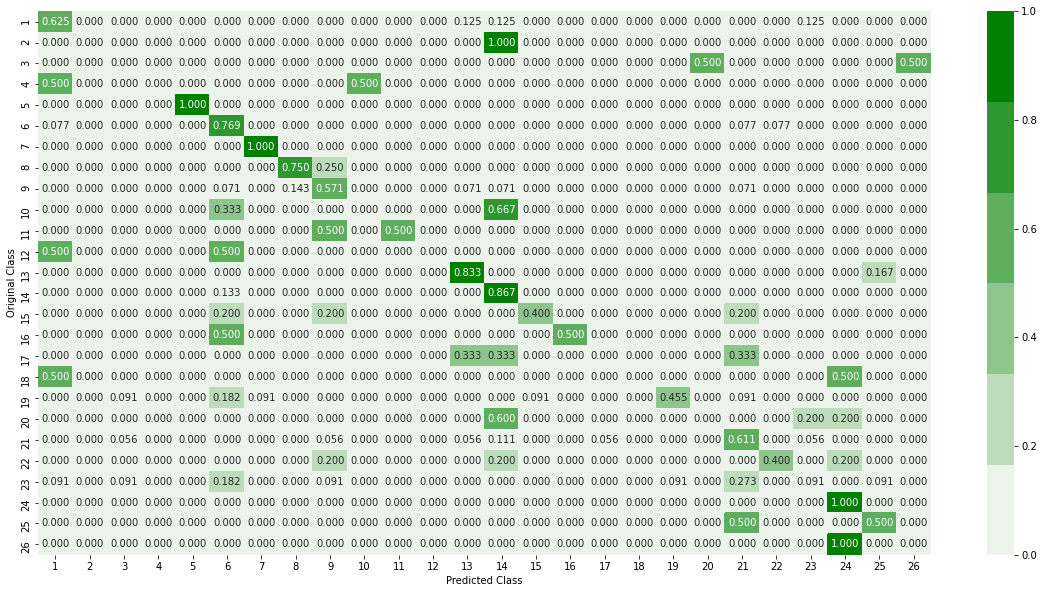

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [ ]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

  
alpha = [x for x in range(1, 23, 2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## 4.2 Logistic Regression for multiclass using Universal sentence encoder embeddings

log_loss for c =  1e-05 is 1.7429954691106244
log_loss for c =  0.0001 is 1.6388859180713538
log_loss for c =  0.001 is 1.6410567206722044
log_loss for c =  0.01 is 1.6400416648821303
log_loss for c =  0.1 is 1.6306616434463648
log_loss for c =  1 is 1.587208723552538
log_loss for c =  10 is 1.5838541592115556
log_loss for c =  100 is 1.613395797916287
log_loss for c =  1000 is 1.6298574728541833


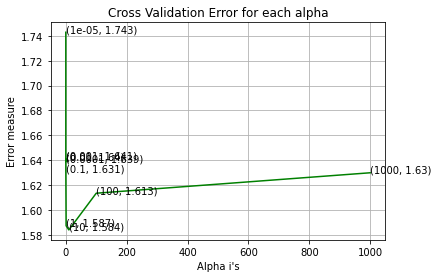

log loss for train data 0.9670245326614465
log loss for cv data 1.5838541592115556
log loss for test data 1.649979382576901
Micro F1 score: 0.6167664670658682
Macro F1 score: 0.5005343432919727
Number of misclassified points  38.32335329341318
-------------------------------------------------- Confusion matrix --------------------------------------------------


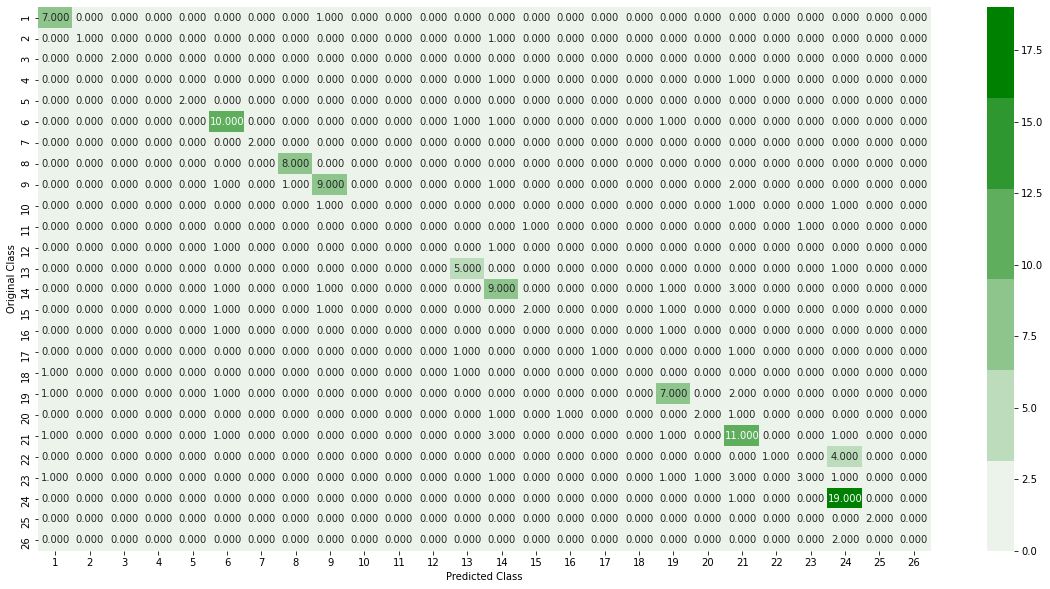

-------------------------------------------------- Precision matrix --------------------------------------------------


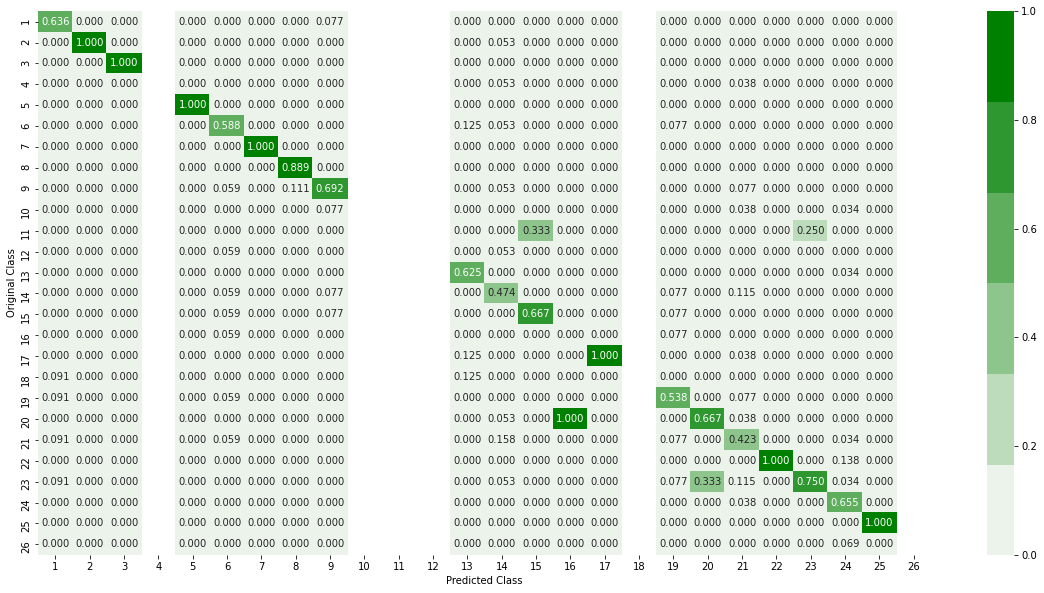

Sum of columns in precision matrix [ 1.  1.  1. nan  1.  1.  1.  1.  1. nan nan nan  1.  1.  1.  1.  1. nan
  1.  1.  1.  1.  1.  1.  1. nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


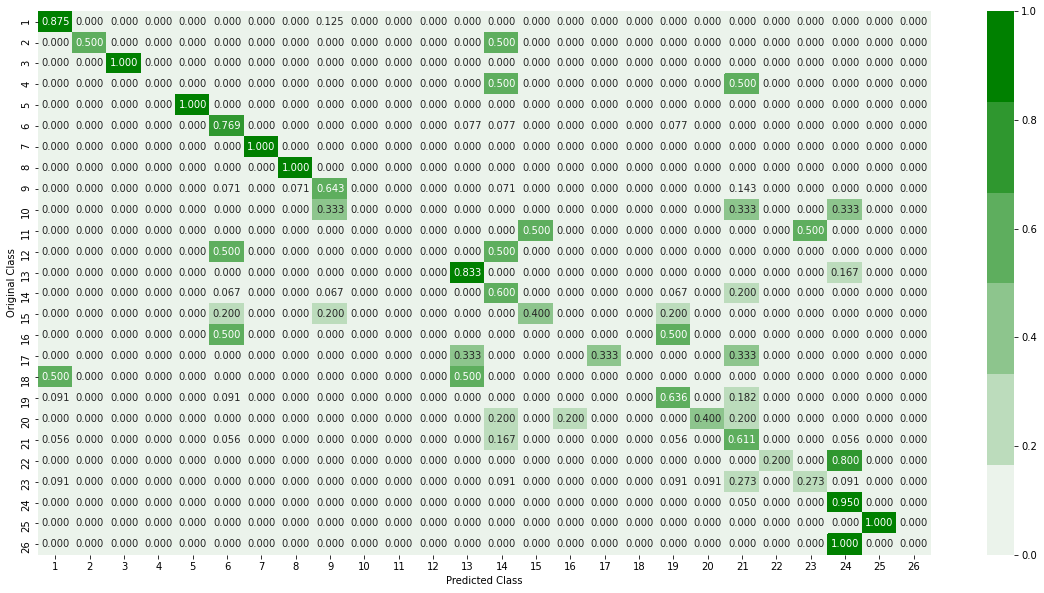

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [73]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------
from sklearn.metrics import f1_score, log_loss, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,)
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],)
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
print("Micro F1 score: {}".format(f1_score(y_test, pred_y, labels=logisticR.classes_, average="micro")))
print("Macro F1 score: {}".format(f1_score(y_test, pred_y, labels=logisticR.classes_, average="macro")))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## 4.3 Random forest for multiclass using Universal sentence encoder embeddings

log_loss for c =  10 is 2.353615713308044
log_loss for c =  50 is 1.9146150187739905
log_loss for c =  100 is 1.7727968017635578
log_loss for c =  500 is 1.6136041196369804
log_loss for c =  1000 is 1.5544228962756461
log_loss for c =  2000 is 1.52386810637939
log_loss for c =  3000 is 1.523952231236217


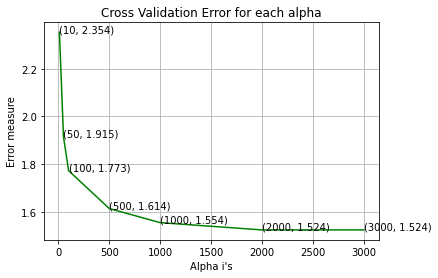

For values of best alpha =  2000 The train log loss is: 0.3726056213983989
For values of best alpha =  2000 The cross validation log loss is: 1.52386810637939
For values of best alpha =  2000 The test log loss is: 1.6464702221772702
Number of misclassified points  40.7185628742515
-------------------------------------------------- Confusion matrix --------------------------------------------------


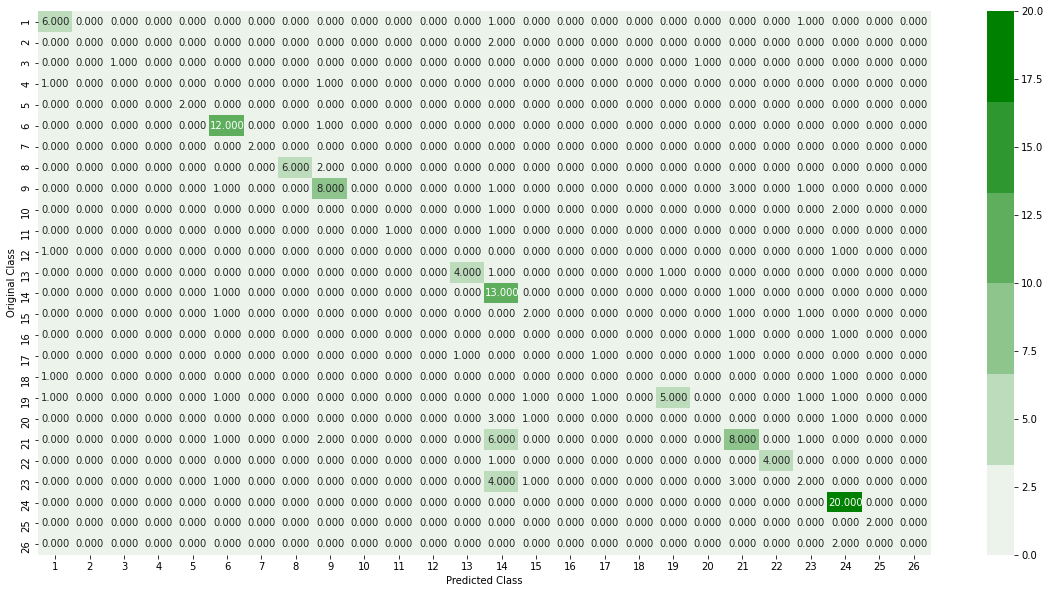

-------------------------------------------------- Precision matrix --------------------------------------------------


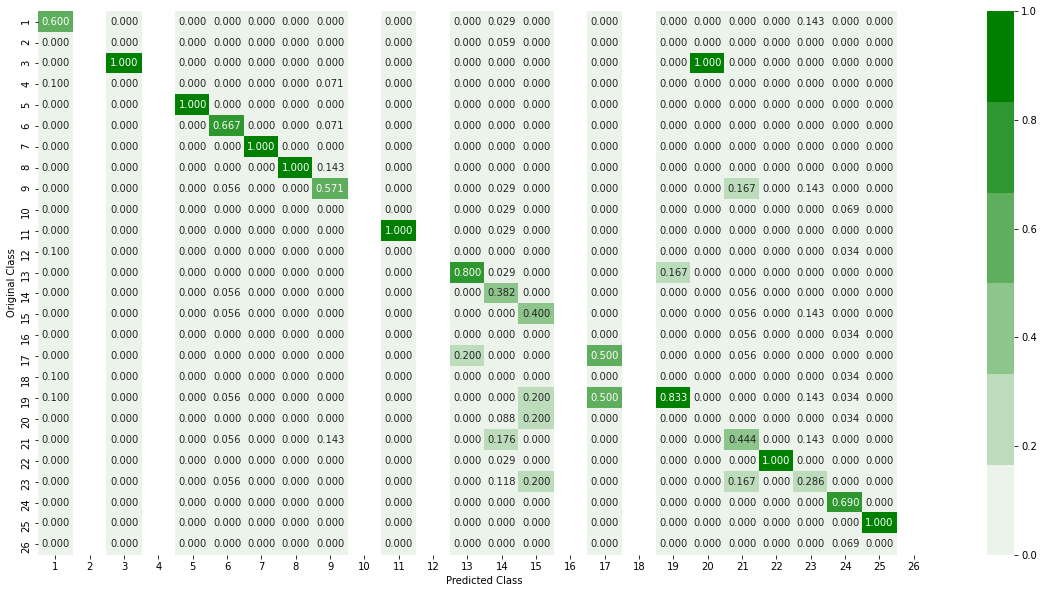

Sum of columns in precision matrix [ 1. nan  1. nan  1.  1.  1.  1.  1. nan  1. nan  1.  1.  1. nan  1. nan
  1.  1.  1.  1.  1.  1.  1. nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


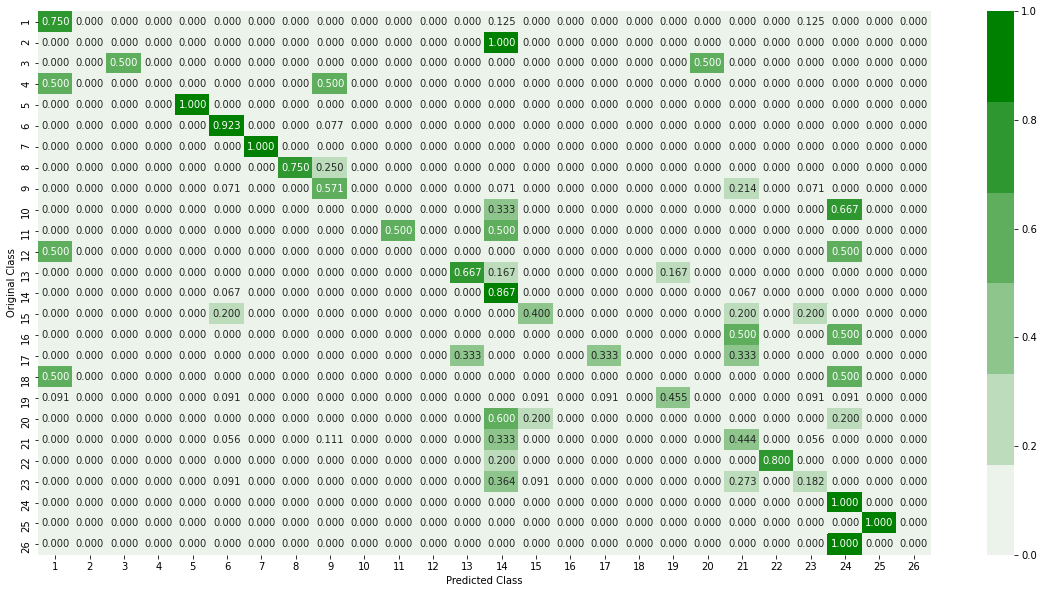

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## 4.4 XG boost for multiclass using Universal sentence encoder embeddings

log_loss for c =  10 is 2.092321566060843
log_loss for c =  50 is 1.9036858145092812
log_loss for c =  100 is 1.8570714869945357
log_loss for c =  500 is 1.8330369161855766
log_loss for c =  1000 is 1.8332061134044497
log_loss for c =  2000 is 1.8332114710660332


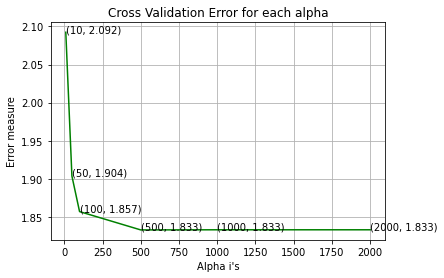

For values of best alpha =  500 The train log loss is: 0.7536604802427354
For values of best alpha =  500 The cross validation log loss is: 1.8330369161855766
For values of best alpha =  500 The test log loss is: 1.9835953824207737
Number of misclassified points  46.706586826347305
-------------------------------------------------- Confusion matrix --------------------------------------------------


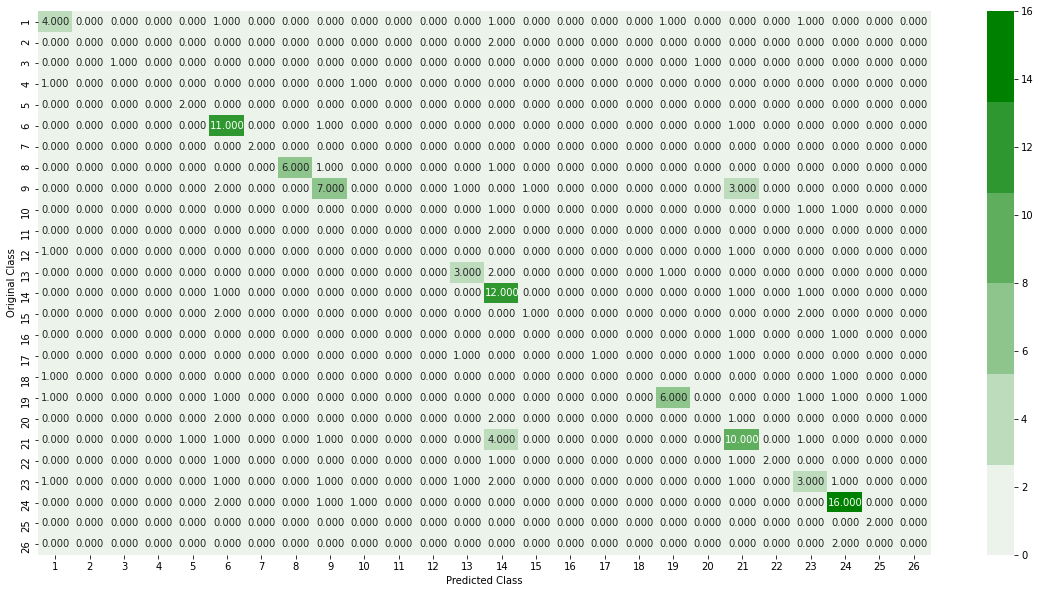

-------------------------------------------------- Precision matrix --------------------------------------------------


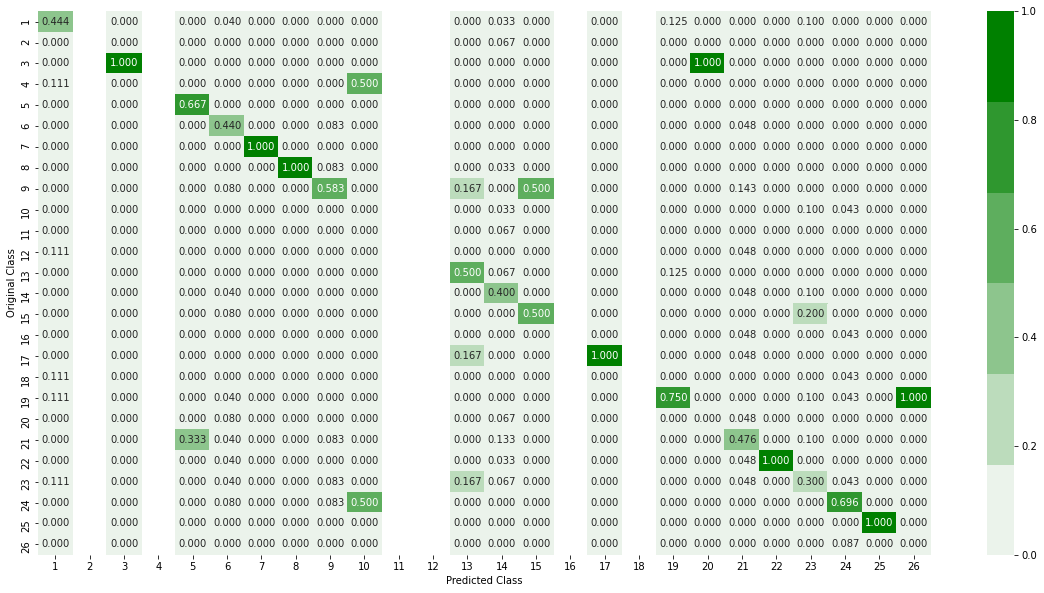

Sum of columns in precision matrix [ 1. nan  1. nan  1.  1.  1.  1.  1.  1. nan nan  1.  1.  1. nan  1. nan
  1.  1.  1.  1.  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


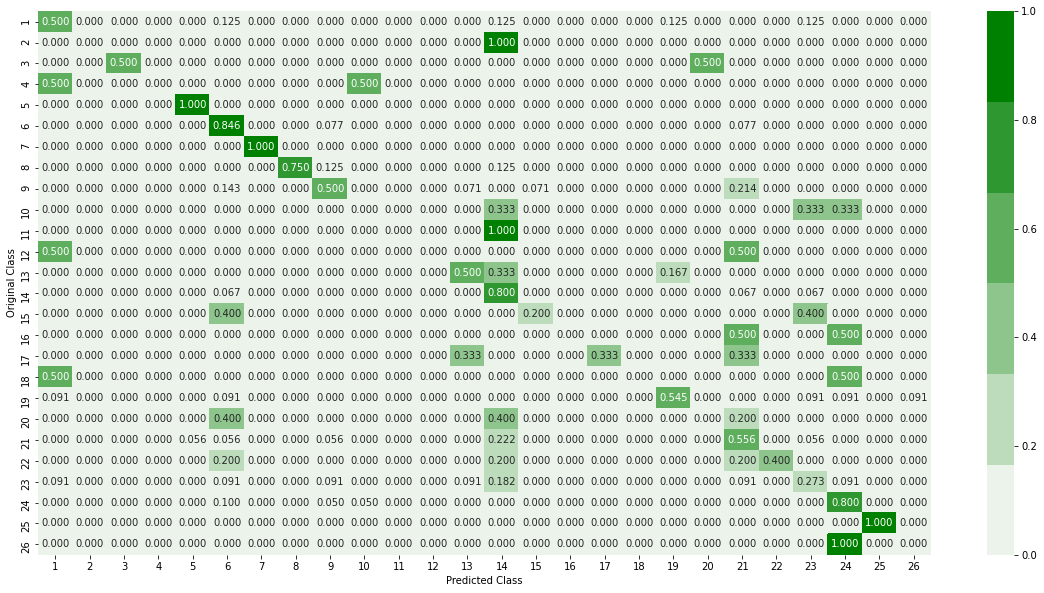

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------
from xgboost import XGBClassifier
alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## Observation - Logisitc regression seems to be performing at par with the other advanced tree based models hence we go ahead with Logistic regression

# 5. Regression model for predicting sentiment

In [2]:
# read train data
df = pd.read_csv("/content/drive/MyDrive/datasets/case study1: aspect based sentiment analysis/01.data/train_final.csv")
print(df.shape)
df.drop(["snippets", "combined", "news"], axis=1, inplace=True)
# read train data
df_val = pd.read_csv("/content/drive/MyDrive/datasets/case study1: aspect based sentiment analysis/01.data/val.csv")
print(df_val.shape)

df_sentiment = pd.concat([df, df_val])
df_sentiment.shape

(1111, 7)
(192, 4)


(1303, 4)

In [3]:
df_sentiment.head()

,aspects,sentiments,target,sentence
0,Corporate/Appointment,-0.374,Royal Mail,Royal Mail chairman Donald Brydon set to step ...
1,Market/Volatility/Volatility,-0.827,Weir,Slump in Weir leads FTSE down from record high
2,Corporate/Regulatory,0.549,AstraZeneca,AstraZeneca wins FDA approval for key new lung...
3,Corporate/Strategy,-0.266,Lloyds,UPDATE 1-Lloyds to cut 945 jobs as part of 3-y...
4,Corporate/Strategy,-0.461,Standard Chartered,Standard Chartered Shifts Emerging-Markets Str...


In [7]:
# preprocessing
df_sentiment["sentence"] = [clean_sentence(x) for x in df_sentiment.sentence]
df_sentiment["aspects"] = [x.split("/")[1] for x in df_sentiment.aspects]
df_sentiment.drop(["target"], axis=1, inplace=True)
df_sentiment["aspects"] = [x.lower() for x in df_sentiment.aspects]

In [8]:
# featurization
# encoding using Universal sentence encoder
# using universal sentence encoder for text embedding
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


embeddings_data_use = embed(df_sentiment.sentence)
embeddings_data_use = np.array(embeddings_data_use)
embeddings_data_use.shape

(1303, 512)

In [9]:
# glove vectors for aspects 300 dim
'''
6. For every model use predefined Glove vectors. 
Don't train any word vectors while Training the model.
'''
from tqdm import tqdm
# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/drive/MyDrive/datasets/cnn_document_classification/glove.6B.300d.txt', encoding="utf8")
for line in tqdm(f):
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

400000it [00:40, 9890.70it/s] 

Loaded 400000 word vectors.


In [10]:
# create embeddings for each word in the traing data
embedding_matrix = np.zeros((df_sentiment.shape[0], 300))
i = 0
for word in [x for x in df_sentiment.aspects]:
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
  i+=1

print(embedding_matrix.shape)

(1303, 300)


In [11]:
# set 1 - feature set
X = np.concatenate((embeddings_data_use, embedding_matrix), axis=1)
y = df_sentiment.sentiments.values
print("Final Data matrix")
print(X.shape, y.shape)
print("="*100)

Final Data matrix
(1303, 812) (1303,)


In [12]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((1042, 812), (261, 812))

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [30]:
# baseline model
lr = LinearRegression()
lr.fit(x_train, y_train)
pred_y = lr.predict(x_train)
prediction = lr.predict(x_test)
print("training mse: {} and r2 score: {}".format(mean_squared_error(y_train, pred_y), r2_score(y_train, pred_y)))
print("testing mse: {} and r2 score: {}".format(mean_squared_error(y_test, prediction), r2_score(y_test, prediction)))

training mse: 0.051704400447837265 and r2 score: 0.6864886256377161
testing mse: 0.24594178496197763 and r2 score: -0.43089197108493704


In [29]:
# KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

knn = KNeighborsRegressor()
distributions = dict(n_neighbors = [3,5,7,9,15,17,21,23])
clf = RandomizedSearchCV(knn, distributions,n_jobs=-1, cv=5)
search = clf.fit(x_train, y_train)
print("Best Params :{}".format(search.best_params_))
knn = clf.best_estimator_
knn.fit(x_train, y_train)
pred_y = knn.predict(x_train)
prediction = knn.predict(x_test)
print("training mse: {} and r2 score: {}".format(mean_squared_error(y_train, pred_y), r2_score(y_train, pred_y)))
print("testing mse: {} and r2 score: {}".format(mean_squared_error(y_test, prediction), r2_score(y_test, prediction)))

Best Params :{'n_neighbors': 17}
training mse: 0.12055396034044191 and r2 score: 0.26901699925370415
testing mse: 0.15801936224794177 and r2 score: 0.08064163740415942


In [31]:
# Randomforest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
distributions = dict(n_estimators = [10,50,100,300,500,1000])
clf = RandomizedSearchCV(rf, distributions,n_jobs=-1, cv=5)
search = clf.fit(x_train, y_train)
print("Best Params :{}".format(search.best_params_))
rf = clf.best_estimator_
rf.fit(x_train, y_train)
pred_y = rf.predict(x_train)
prediction = rf.predict(x_test)
print("training mse: {} and r2 score: {}".format(mean_squared_error(y_train, pred_y), r2_score(y_train, pred_y)))
print("testing mse: {} and r2 score: {}".format(mean_squared_error(y_test, prediction), r2_score(y_test, prediction)))

Best Params :{'n_estimators': 500}
training mse: 0.016902393595447478 and r2 score: 0.8975117668859333
testing mse: 0.12614096057165858 and r2 score: 0.26611052394032164


In [50]:
# xgboost
from xgboost import XGBRegressor
xg = XGBRegressor()
distributions = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                  "min_child_weight" : [ 1, 3, 5, 7 ],
                  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                  "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }
clf = RandomizedSearchCV(xg, distributions,n_jobs=-1, cv=5)
search = clf.fit(x_train, y_train)
print("Best Params :{}".format(search.best_params_))
xg = clf.best_estimator_
xg.fit(x_train, y_train)
pred_y = xg.predict(x_train)
prediction = xg.predict(x_test)
print("training mse: {} and r2 score: {}".format(mean_squared_error(y_train, pred_y), r2_score(y_train, pred_y)))
print("testing mse: {} and r2 score: {}".format(mean_squared_error(y_test, prediction), r2_score(y_test, prediction)))

[07:57:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Params :{'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.3}
[07:58:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
training mse: 0.035859551924658145 and r2 score: 0.7825643985707311
testing mse: 0.12612526756848141 and r2 score: 0.2662018260029291


# Conclusion: 
We will use 3 models here:
- ## KNN for binary classification with AUC of 0.90
- ## logistic regression for multiclass classification with the below scores
-- log loss for train data 1.1118204301243366
-- log loss for cv data 1.5606928236570707
-- log loss for test data 1.6058149937122996
-- Micro F1 score: 0.612814371257485
-- Number of misclassified points  40.7185628742515
- ## Randomforest for our regression problem: predicting sentiment scores with the below scores
-- training mse: 0.016902393595447478 and r2 score: 0.8975117668859333
-- testing mse: 0.12614096057165858 and r2 score: 0.26611052394032164

# The above scores beat the scores used in the reference paper
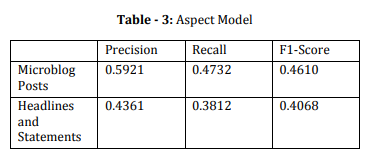

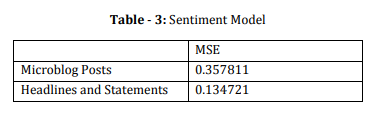